# CareHarmony Case Study

You will be using the CMS 2008-2010 Data Entrepreneurs Synthetic PUF beneficiary data files for this project. This dataset is a bit old, but it is a large synthetic dataset that closely mirrors the type of data that we work with. Due to file size limitations, each data type in the CMS Linkable 2008-2010 Medicare DE-SynPUF is released in 20 separate samples (essentially each is a .25% sample)

The DE-SynPUF contains five types of data for the period 2008-2010:
* Beneficiary Summary
* Inpatient Claims
* Outpatient Claims
* Carrier Claims (not included in the current analysis)
* Prescription Drug Events (not included in the current analysis)


To keep things simple, you will be primarily utilizing the beneficiary-level files that can be found in the zip file attached. These data files contain high-level summaries of patient demographics, conditions, and spending for each of the years 2008, 2009, and 2010. It is organized into twenty separate files for each year and organized such that the same patients are retained in each of the yearly files sharing the same index number. Ten files per year are included for completeness, but you may use as many as you like to conduct your analysis. Note that the dataset is indeed synthetic so many relationships we would expect to see in real world data may not hold. Accordingly, in our evaluation we will focus more on your analytical approach than the actual results.

The original source of the files can be found at this link: https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DESample01. Translations for a lot of the common terms provided in the Beneficiary Summary file can be found at this link: https://www.cms.gov/files/document/de-10-codebook.pdf-0.

# CareHarmony Case Study: predictive modeling

The health system is interested in identifying and prioritizing patients who are at risk of experiencing a spike in costs in 2011. Use the beneficiary data from 2008-2010 to develop a model to address this concern and explain how you would use it to select a set of patients to prioritize in 2011. Please also make sure to explain your model selection and validation procedure.

In [5]:
import os
import time

import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from xgboost import plot_importance

from matplotlib import pyplot as plt
import seaborn as sns

Beneficiary data processing

In [6]:
start_time = time.time()

# Define the base directory for our CSV files
base_dir = r'C:\code_personal_use\cms\data\bene'

# List of years we have data for
years = [2008, 2009, 2010]

# Columns to use for each year
columns_2008 = [
    'DESYNPUF_ID', 'BENE_BIRTH_DT', 'BENE_SEX_IDENT_CD', 'BENE_RACE_CD',
    'SP_STATE_CODE', 'BENE_COUNTY_CD', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN',
    'SP_CNCR', 'BENE_ESRD_IND', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES',
    'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA', 'MEDREIMB_IP',
    'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP',
    'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'
]

columns_2009_2010 = [
    'DESYNPUF_ID', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR',
    'BENE_ESRD_IND', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT',
    'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA', 'MEDREIMB_IP', 'BENRES_IP',
    'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP', 'MEDREIMB_CAR',
    'BENRES_CAR', 'PPPYMT_CAR'
]

# Function to recode BENE_ESRD_IND
def recode_bene_esrd_ind(df, column):
    df[column] = df[column].replace({'Y': 1, '0': 2}).astype(int)
    return df

# Function to rename columns with a suffix
def rename_columns_with_suffix(df, suffix):
    df = df.rename(columns=lambda x: x + suffix if x != 'DESYNPUF_ID' else x)
    return df

# Function to load and preprocess a batch of files for a given year
def load_and_preprocess_batch(file_paths, year):
    columns = columns_2008 if year == 2008 else columns_2009_2010
    parse_dates = ['BENE_BIRTH_DT'] if year == 2008 else None
    date_parser = lambda x: pd.to_datetime(x, format='%Y%m%d') if year == 2008 else None

    # Load and preprocess files in the batch
    dfs = []
    for file_path in file_paths:
        df = pd.read_csv(
            file_path,
            usecols=columns,
            parse_dates=parse_dates,
            date_parser=date_parser
        )
        df = recode_bene_esrd_ind(df, 'BENE_ESRD_IND')
        df = rename_columns_with_suffix(df, f'_{year}')
        dfs.append(df)

    # Concatenate all DataFrames in the batch
    return pd.concat(dfs, ignore_index=True)

# Create a dictionary to store DataFrames for each year
dfs_by_year = {}

# Process files in batches
# Adjust the batch size based on your system's memory
batch_size = 5
for year in years:
    file_paths = [os.path.join(base_dir, f'DE1_0_{year}_Beneficiary_Summary_File_Sample_{i}.csv') for i in range(1, 20)]
    batches = [file_paths[i:i + batch_size] for i in range(0, len(file_paths), batch_size)]

    # Load and preprocess each batch
    year_dfs = []
    for batch in batches:
        batch_df = load_and_preprocess_batch(batch, year)
        year_dfs.append(batch_df)

    # Concatenate all batches for the year
    dfs_by_year[year] = pd.concat(year_dfs, ignore_index=True)

# Merge DataFrames for all years on DESYNPUF_ID
merged_df = dfs_by_year[2008]
for year in years[1:]:
    merged_df = merged_df.merge(dfs_by_year[year], on='DESYNPUF_ID', how='inner')

#####################################################################################################

# Define the prefixes to check for null values
prefixes = [
    'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP',
    'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'
]

# Function to replace null values with 0 for specified prefixes
def replace_nulls_with_zero(df, prefixes):
    for prefix in prefixes:
        cols = [col for col in df.columns if col.startswith(prefix)]
        df[cols] = df[cols].fillna(0)
    return df

merged_df = replace_nulls_with_zero(merged_df, prefixes)

#####################################################################################################

# Calculate Age
def calculate_age(birth_date, reference_date):
    return reference_date.year - birth_date.year - ((reference_date.month, reference_date.day) < (birth_date.month, birth_date.day))

reference_date = datetime.now()  # Using the current date as the reference date
merged_df['Age'] = merged_df['BENE_BIRTH_DT_2008'].apply(lambda x: calculate_age(x, reference_date))

#####################################################################################################

# Display the first few rows of the resulting DataFrame and unique ID counts
print(f'Unique IDs in 2008: {dfs_by_year[2008]["DESYNPUF_ID"].nunique()}')
print(f'Unique IDs in 2009: {dfs_by_year[2009]["DESYNPUF_ID"].nunique()}')
print(f'Unique IDs in 2010: {dfs_by_year[2010]["DESYNPUF_ID"].nunique()}')
print(f'Unique IDs after merging: {merged_df["DESYNPUF_ID"].nunique()}')

print("First few rows of the merged DataFrame:")
print(merged_df.head())

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

Unique IDs in 2008: 2210481
Unique IDs in 2009: 2176679
Unique IDs in 2010: 2142287
Unique IDs after merging: 2142287
First few rows of the merged DataFrame:
        DESYNPUF_ID BENE_BIRTH_DT_2008  BENE_SEX_IDENT_CD_2008  \
0  00013D2EFD8E45D1         1923-05-01                       1   
1  00016F745862898F         1943-01-01                       1   
2  0001FDD721E223DC         1936-09-01                       2   
3  00021CA6FF03E670         1941-06-01                       1   
4  00024B3D2352D2D0         1936-08-01                       1   

   BENE_RACE_CD_2008  BENE_ESRD_IND_2008  SP_STATE_CODE_2008  \
0                  1                   2                  26   
1                  1                   2                  39   
2                  1                   2                  39   
3                  5                   2                   6   
4                  1                   2                  52   

   BENE_COUNTY_CD_2008  SP_ALZHDMTA_2008  SP_CHF_2008  SP_CH

In [7]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2142287 entries, 0 to 2142286
Data columns (total 70 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   DESYNPUF_ID             object        
 1   BENE_BIRTH_DT_2008      datetime64[ns]
 2   BENE_SEX_IDENT_CD_2008  int64         
 3   BENE_RACE_CD_2008       int64         
 4   BENE_ESRD_IND_2008      int32         
 5   SP_STATE_CODE_2008      int64         
 6   BENE_COUNTY_CD_2008     int64         
 7   SP_ALZHDMTA_2008        int64         
 8   SP_CHF_2008             int64         
 9   SP_CHRNKIDN_2008        int64         
 10  SP_CNCR_2008            int64         
 11  SP_COPD_2008            int64         
 12  SP_DEPRESSN_2008        int64         
 13  SP_DIABETES_2008        int64         
 14  SP_ISCHMCHT_2008        int64         
 15  SP_OSTEOPRS_2008        int64         
 16  SP_RA_OA_2008           int64         
 17  SP_STRKETIA_2008        int64         
 18  ME

In [8]:
pd.options.display.float_format = '{:.2f}'.format
merged_df.describe(())

,BENE_SEX_IDENT_CD_2008,BENE_RACE_CD_2008,BENE_ESRD_IND_2008,SP_STATE_CODE_2008,BENE_COUNTY_CD_2008,SP_ALZHDMTA_2008,SP_CHF_2008,SP_CHRNKIDN_2008,SP_CNCR_2008,SP_COPD_2008,...,MEDREIMB_IP_2010,BENRES_IP_2010,PPPYMT_IP_2010,MEDREIMB_OP_2010,BENRES_OP_2010,PPPYMT_OP_2010,MEDREIMB_CAR_2010,BENRES_CAR_2010,PPPYMT_CAR_2010,Age
count,2142287.00,2142287.00,2142287.00,2142287.00,2142287.00,2142287.00,2142287.00,2142287.00,2142287.00,2142287.00,...,2142287.00,2142287.00,2142287.00,2142287.00,2142287.00,2142287.00,2142287.00,2142287.00,2142287.00,2142287.00
mean,1.56,1.28,1.93,25.72,365.56,1.81,1.72,1.84,1.94,1.86,...,1244.05,144.82,52.38,433.68,131.41,15.04,847.80,239.45,12.85,87.14
std,0.50,0.75,0.26,15.57,266.17,0.39,0.45,0.37,0.24,0.34,...,5141.76,565.59,1379.28,1273.11,368.06,277.44,999.52,284.40,73.20,12.58
min,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,...,-8000.00,0.00,0.00,-100.00,0.00,0.00,0.00,0.00,0.00,40.00
50%,2.00,1.00,2.00,25.00,330.00,2.00,2.00,2.00,2.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,540.00,150.00,0.00,88.00
max,2.00,5.00,2.00,54.00,999.00,2.00,2.00,2.00,2.00,2.00,...,156690.00,37300.00,83000.00,40510.00,11040.00,18000.00,16530.00,3590.00,3000.00,115.00


Looks like we have some negative values for our cost-related features. Let's explore a bit.

Are these reversals?

Check to see if ALL values in the REIMB 08, 09, 10 fields are negative. The min is always negative and the 75%tile is always 0.

If these are supposed to be reversals, then they should sum to zero for each patient. If they don't sum to zero, then the synthetic data generator (Synthea?) hasn't replicated irl medical claims data accurately.

Summary Statistics for Selected Columns:

                       count    mean     std       min   25%    50%     75%  \
MEDREIMB_IP_2008  2142287.00 2213.35 8446.53  -8000.00  0.00   0.00    0.00   
BENRES_IP_2008    2142287.00  249.24  866.72      0.00  0.00   0.00    0.00   
PPPYMT_IP_2008    2142287.00  104.40 1937.91      0.00  0.00   0.00    0.00   
MEDREIMB_OP_2008  2142287.00  630.14 1800.24   -100.00  0.00  20.00  570.00   
BENRES_OP_2008    2142287.00  199.36  521.52      0.00  0.00   0.00  190.00   
PPPYMT_OP_2008    2142287.00   25.17  358.50      0.00  0.00   0.00    0.00   
MEDREIMB_CAR_2008 2142287.00 1173.68 1594.45      0.00  0.00 620.00 1660.00   
BENRES_CAR_2008   2142287.00  331.94  438.84      0.00  0.00 180.00  480.00   
PPPYMT_CAR_2008   2142287.00   18.85   90.06      0.00  0.00   0.00    0.00   
MEDREIMB_IP_2009  2142287.00 2196.59 7281.79 -10000.00  0.00   0.00    0.00   
BENRES_IP_2009    2142287.00  250.05  782.07      0.00  0.00   0.00    0.00   
PPPYMT_IP_

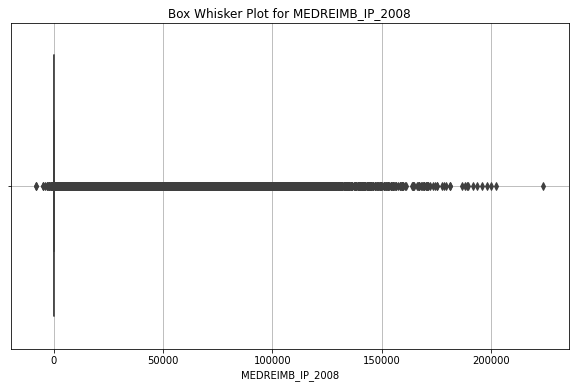

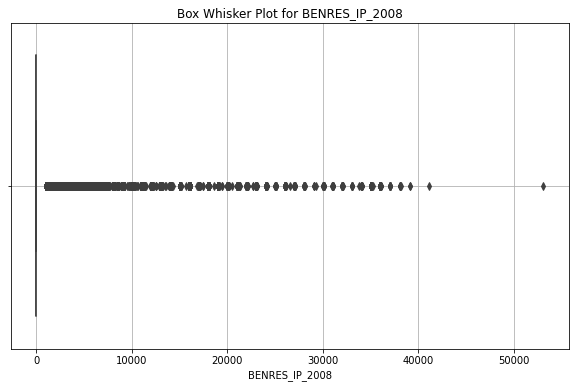

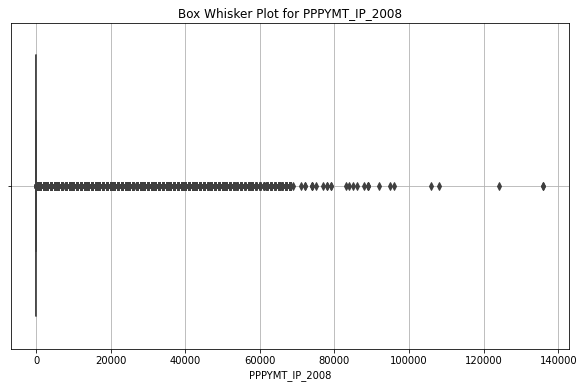

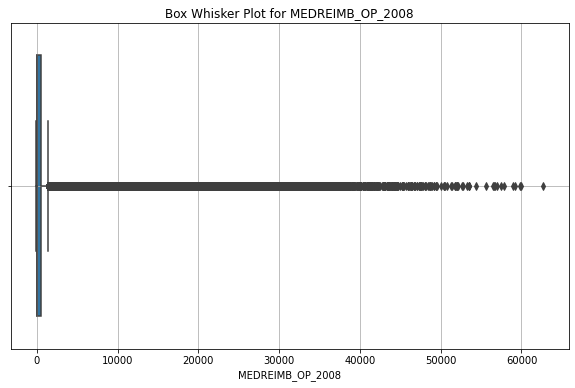

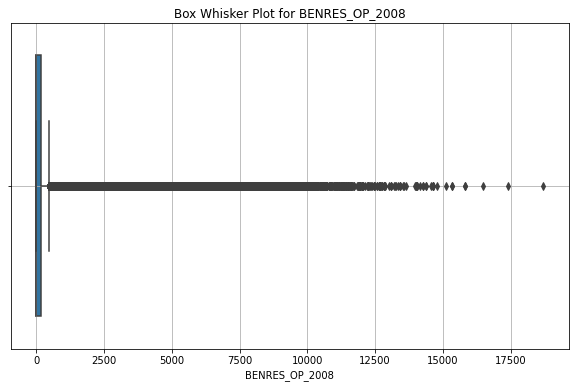

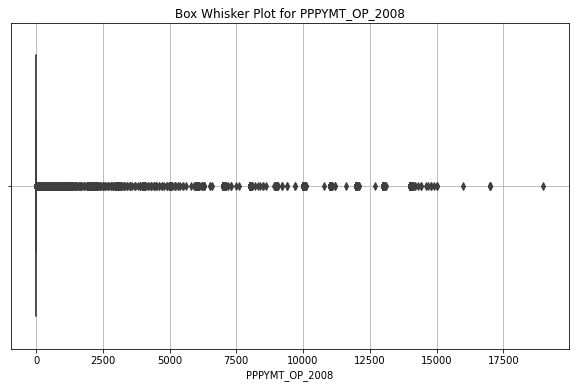

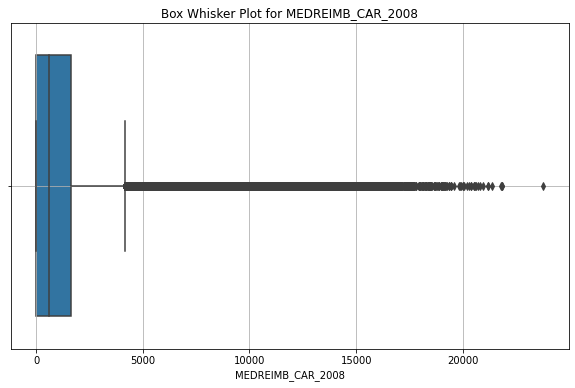

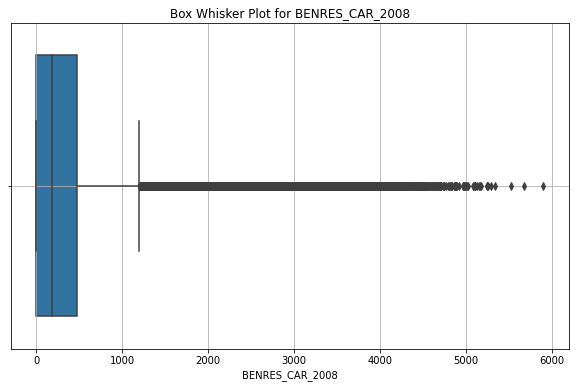

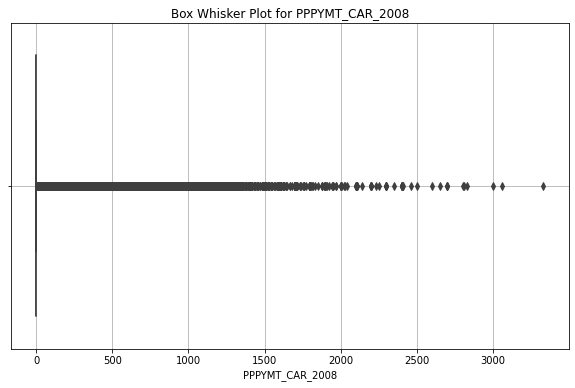

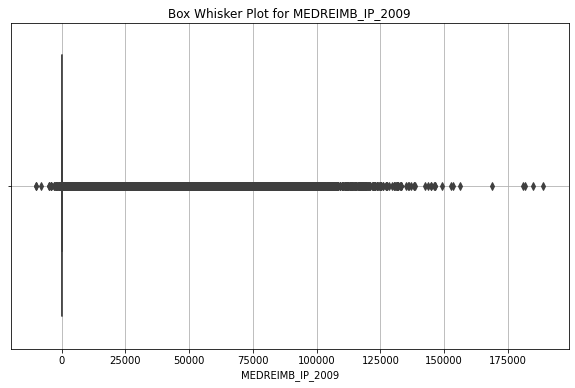

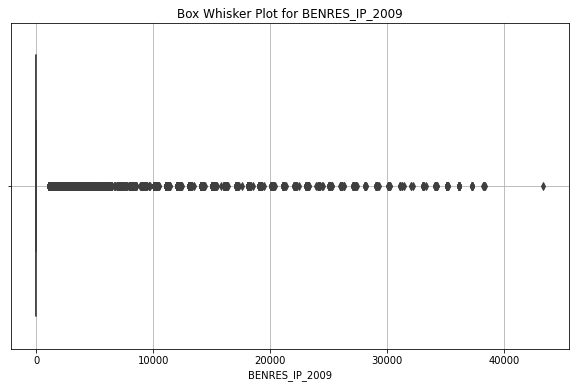

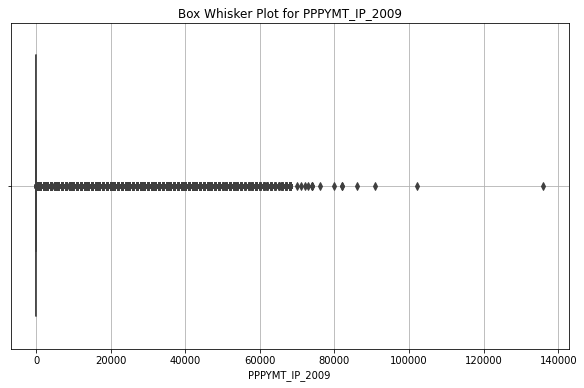

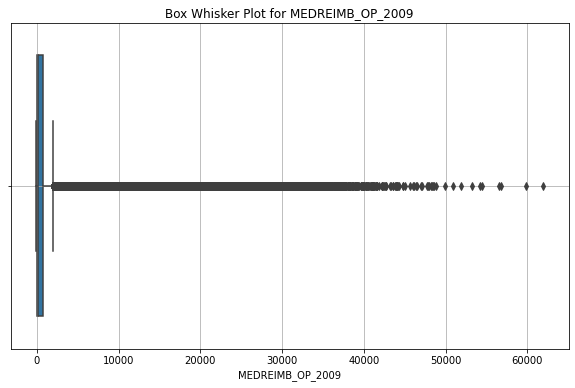

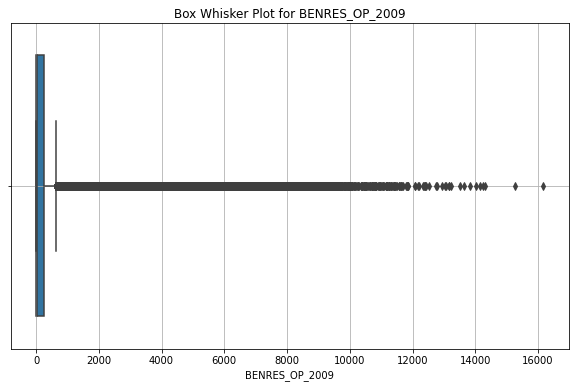

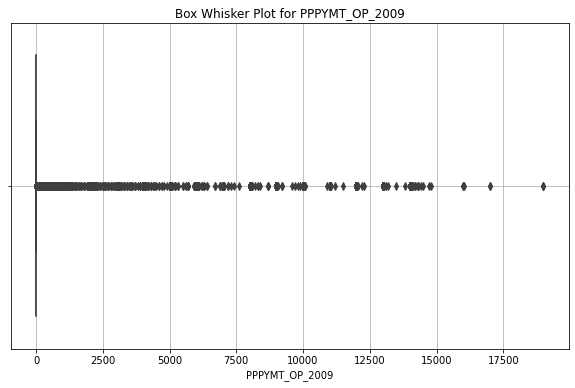

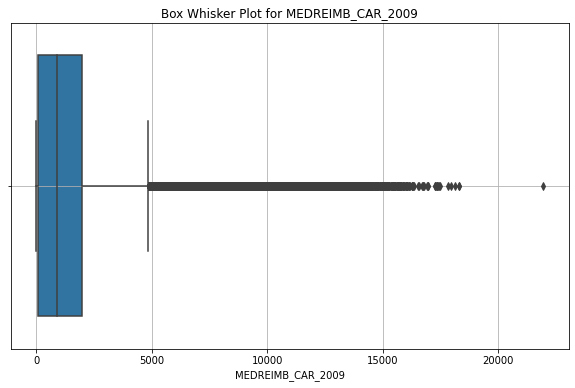

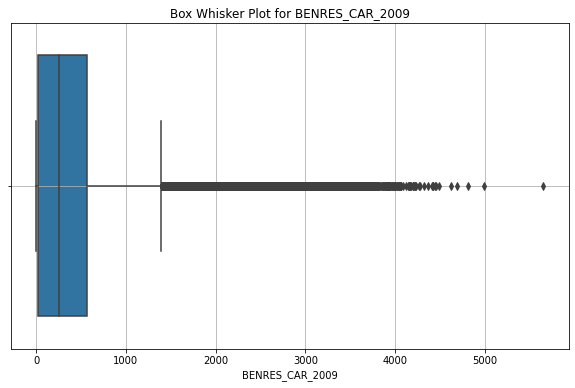

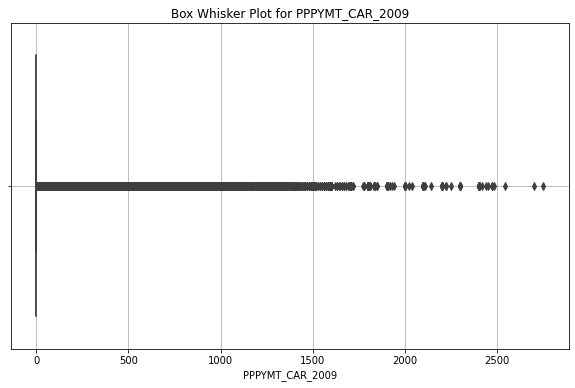

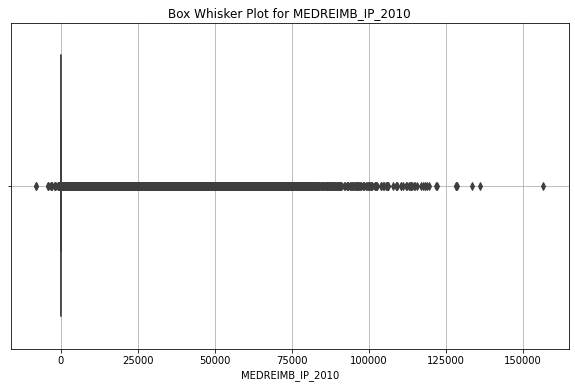

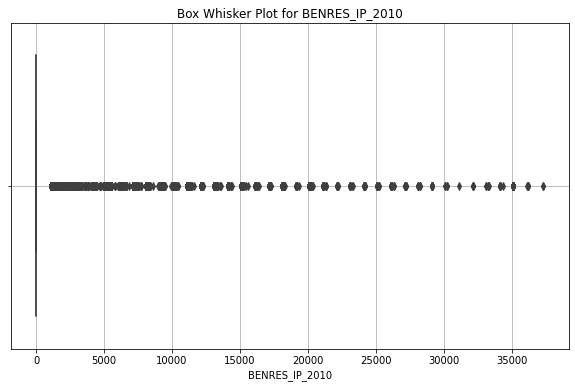

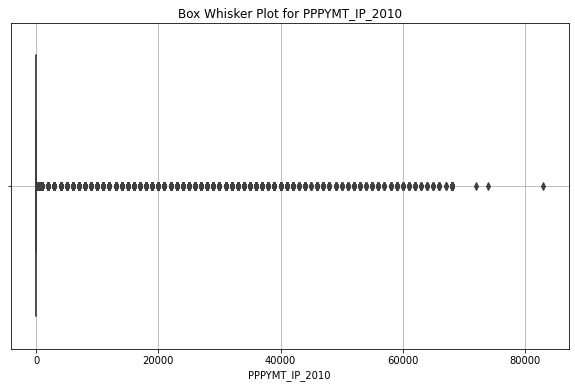

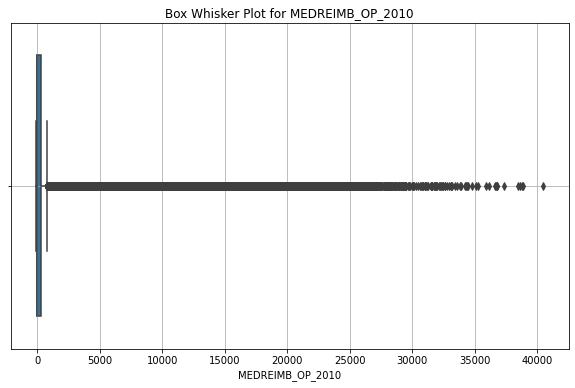

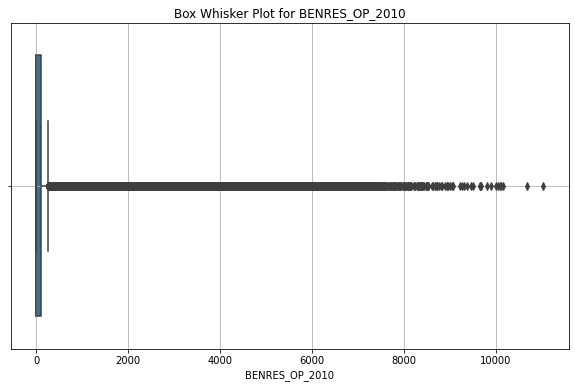

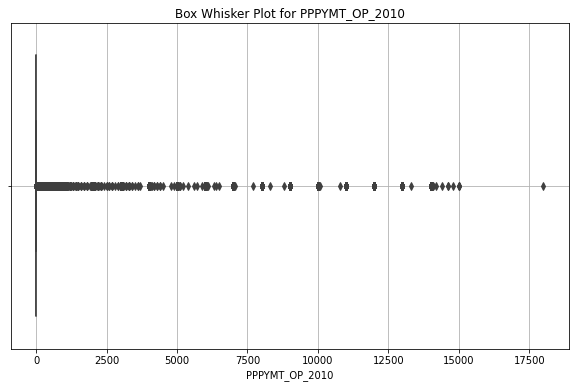

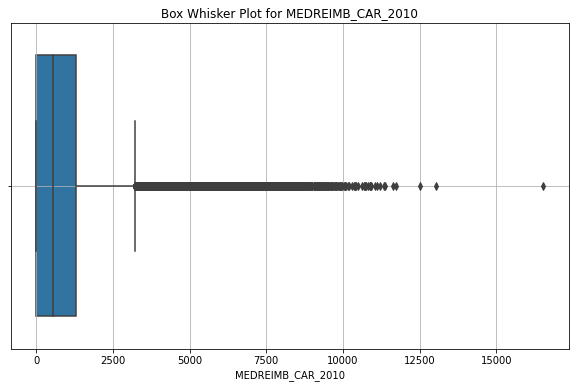

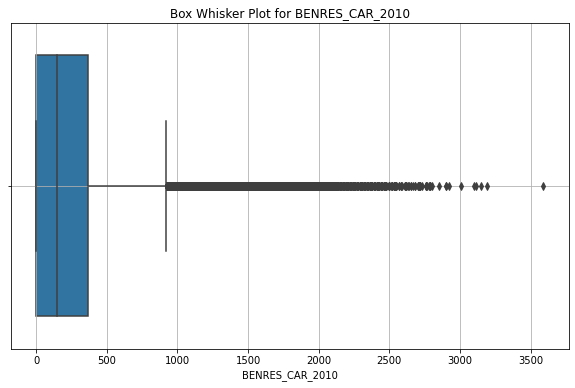

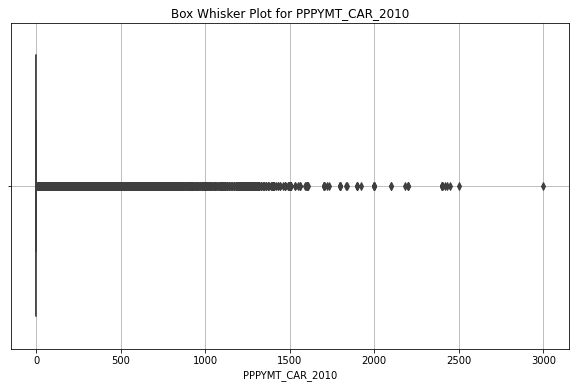

In [9]:
# Define the prefixes
prefixes = [
    'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP',
    'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP',
    'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'
]

# Filter columns based on prefixes
filtered_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in prefixes)]

# Calculate summary statistics
summary_stats = merged_df[filtered_columns].describe().T

# Print summary statistics
print("Summary Statistics for Selected Columns:\n")
print(summary_stats)

# Create box whisker plots
for col in filtered_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=merged_df[col])
    plt.title(f"Box Whisker Plot for {col}")
    plt.xlabel(col)
    plt.grid(True)
    plt.show()

In [10]:
# Specify the prefixes to filter columns
prefixes = [
    'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP',
    'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'
]

# Identify columns with the specified prefixes
columns_to_check = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in prefixes)]

# Identify rows where any of the specified columns contain values less than 0
rows_with_negatives = merged_df[(merged_df[columns_to_check] < 0).any(axis=1)]

# Specify the output path for QA of this df
output_path = r'C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\negative_values.csv'

# Save the filtered DataFrame to a CSV file
rows_with_negatives.to_csv(output_path, index=False)

print(f"DataFrame with negative values saved to {output_path}")

DataFrame with negative values saved to C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\negative_values.csv


Need to work on optimizing this step. It currently takes a little over 5 mins of run time to finish merging all 20 beneficiary files

In [11]:
start_time = time.time()

# Filter to include only the specific DESYNPUF_ID for EDA and QA
# merged_df = merged_df[merged_df['DESYNPUF_ID'] == '00016F745862898F']

# List of columns to sum across years
columns_to_sum = [
    'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP',
    'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP',
    'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'
]

# Loop through each column and create a new column for the sum across the three years
for col in columns_to_sum:
    merged_df[col + '_SUM'] = merged_df[col + '_2008'] + merged_df[col + '_2009'] + merged_df[col + '_2010']

# Create a list of columns that end with '_SUM'
sum_columns = [col + '_SUM' for col in columns_to_sum]

# Add a new column 'total_sum' that sums all columns ending with '_SUM'
merged_df['total_sum'] = merged_df[sum_columns].sum(axis=1)

# Extract additional columns from the 2008 dataset to serve as our demographic features
additional_columns_08 = merged_df[['DESYNPUF_ID', 'BENE_BIRTH_DT_2008', 'Age', 'BENE_SEX_IDENT_CD_2008', 'BENE_RACE_CD_2008', 'SP_STATE_CODE_2008', 'BENE_COUNTY_CD_2008']]
# Rename columns to more human-readable names
additional_columns_08 = additional_columns_08.rename(columns={
    'BENE_BIRTH_DT_2008': 'Birth_Date',
    'BENE_SEX_IDENT_CD_2008': 'Gender',
    'BENE_RACE_CD_2008': 'Race',
    'SP_STATE_CODE_2008': 'State',
    'BENE_COUNTY_CD_2008': 'County'
})

# Export the wide format DataFrame to a CSV file for QA
# output_path_wide = r'C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\merged_data_wide.csv'
# merged_df.to_csv(output_path_wide, index=False)

# Reshape the DataFrame from wide to long format for the specified columns
columns_to_reshape = ['DESYNPUF_ID'] + [col + suffix for col in columns_to_sum for suffix in ['_2008', '_2009', '_2010']]
df_wide = merged_df[columns_to_reshape]

# Use pd.melt to reshape the DataFrame to long format
df_long = pd.melt(df_wide, id_vars=['DESYNPUF_ID'],
                  value_vars=[col + suffix for col in columns_to_sum for suffix in ['_2008', '_2009', '_2010']],
                  var_name='Year_Column', value_name='Value')

# Split the 'Year_Column' to extract the year information and the original column name
df_long['Year'] = df_long['Year_Column'].str.extract(r'(\d{4})$')
df_long['Column'] = df_long['Year_Column'].str.replace(r'_\d{4}$', '')

# Convert 'Year' to integer
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Sum 'Value' by 'Year' and 'DESYNPUF_ID' to create 'annual_cost'
annual_cost = df_long.groupby(['DESYNPUF_ID', 'Year'])['Value'].sum().reset_index()
annual_cost.rename(columns={'Value': 'annual_cost'}, inplace=True)

# Finalize the long format DataFrame to include DESYNPUF_ID, Year, and annual_cost
df_long_final = annual_cost

# Merge additional columns from 2008 dataset
df_long_final = df_long_final.merge(additional_columns_08, on='DESYNPUF_ID', how='left')

# Export the long format DataFrame to a CSV file
output_path_long = r'C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\merged_data_long.csv'
df_long_final.to_csv(output_path_long, index=False)

# Display the first few rows of the resulting DataFrames
print("Wide format DataFrame:")
print(merged_df.head())
print("\nLong format DataFrame:")
print(df_long_final.head())

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

C:\Users\JoeCarhart\AppData\Local\Temp\ipykernel_38960\348429611.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  df_long['Column'] = df_long['Year_Column'].str.replace(r'_\d{4}$', '')


Wide format DataFrame:
        DESYNPUF_ID BENE_BIRTH_DT_2008  BENE_SEX_IDENT_CD_2008  \
0  00013D2EFD8E45D1         1923-05-01                       1   
1  00016F745862898F         1943-01-01                       1   
2  0001FDD721E223DC         1936-09-01                       2   
3  00021CA6FF03E670         1941-06-01                       1   
4  00024B3D2352D2D0         1936-08-01                       1   

   BENE_RACE_CD_2008  BENE_ESRD_IND_2008  SP_STATE_CODE_2008  \
0                  1                   2                  26   
1                  1                   2                  39   
2                  1                   2                  39   
3                  5                   2                   6   
4                  1                   2                  52   

   BENE_COUNTY_CD_2008  SP_ALZHDMTA_2008  SP_CHF_2008  SP_CHRNKIDN_2008  ...  \
0                  950                 2            2                 2  ...   
1                  230             

In [12]:
df_long_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6426861 entries, 0 to 6426860
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   DESYNPUF_ID  object        
 1   Year         int64         
 2   annual_cost  float64       
 3   Birth_Date   datetime64[ns]
 4   Age          int64         
 5   Gender       int64         
 6   Race         int64         
 7   State        int64         
 8   County       int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 490.3+ MB


This code block needs further optimization. It currently takes close to 6 mins to process the diagnosis data for all 20 samples of beneficiary data

In [13]:
start_time = time.time()

# Define the diagnosis columns and prefixes
diagnosis_columns = [
    'DESYNPUF_ID',
    'SP_ALZHDMTA_2008', 'SP_CHF_2008', 'SP_CHRNKIDN_2008', 'SP_CNCR_2008', 'SP_COPD_2008',
    'SP_DEPRESSN_2008', 'SP_DIABETES_2008', 'SP_ISCHMCHT_2008', 'SP_OSTEOPRS_2008',
    'SP_RA_OA_2008', 'SP_STRKETIA_2008', 'BENE_ESRD_IND_2008',
    'SP_ALZHDMTA_2009', 'SP_CHF_2009', 'SP_CHRNKIDN_2009', 'SP_CNCR_2009', 'SP_COPD_2009',
    'SP_DEPRESSN_2009', 'SP_DIABETES_2009', 'SP_ISCHMCHT_2009', 'SP_OSTEOPRS_2009',
    'SP_RA_OA_2009', 'SP_STRKETIA_2009', 'BENE_ESRD_IND_2009',
    'SP_ALZHDMTA_2010', 'SP_CHF_2010', 'SP_CHRNKIDN_2010', 'SP_CNCR_2010', 'SP_COPD_2010',
    'SP_DEPRESSN_2010', 'SP_DIABETES_2010', 'SP_ISCHMCHT_2010', 'SP_OSTEOPRS_2010',
    'SP_RA_OA_2010', 'SP_STRKETIA_2010', 'BENE_ESRD_IND_2010'
]

# Create the diagnoses DataFrame from the main DataFrame
diagnoses = merged_df[diagnosis_columns]

# List of diagnosis prefixes
diagnosis_prefixes = [
    'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD',
    'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS',
    'SP_RA_OA', 'SP_STRKETIA', 'BENE_ESRD_IND'
]

# Initialize an empty DataFrame to store the long format data
diagnoses_long_list = []

# Transform each set of columns to long format and append them to the list
for prefix in diagnosis_prefixes:
    columns = [f'{prefix}_2008', f'{prefix}_2009', f'{prefix}_2010']
    df_long = pd.melt(diagnoses, id_vars=['DESYNPUF_ID'], value_vars=columns,
                      var_name='Year', value_name=prefix)
    df_long['Year'] = df_long['Year'].str.extract(r'(\d{4})$').astype(int)
    diagnoses_long_list.append(df_long)

# Combine all long format DataFrames
diagnoses_long = diagnoses_long_list[0]
for df_long in diagnoses_long_list[1:]:
    diagnoses_long = diagnoses_long.merge(df_long, on=['DESYNPUF_ID', 'Year'], how='outer')

# Display the transformed long DataFrame
print("Long format Diagnoses DataFrame:")
print(diagnoses_long)

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

Long format Diagnoses DataFrame:
              DESYNPUF_ID  Year  SP_ALZHDMTA  SP_CHF  SP_CHRNKIDN  SP_CNCR  \
0        00013D2EFD8E45D1  2008            2       2            2        2   
1        00016F745862898F  2008            2       2            2        2   
2        0001FDD721E223DC  2008            2       2            2        2   
3        00021CA6FF03E670  2008            2       2            2        2   
4        00024B3D2352D2D0  2008            2       2            2        2   
...                   ...   ...          ...     ...          ...      ...   
6426856  FFFD961415966F79  2010            2       2            2        2   
6426857  FFFDA4E3D602964B  2010            2       2            2        2   
6426858  FFFEEB065C259516  2010            2       2            2        2   
6426859  FFFFAA8FF082E605  2010            2       1            2        2   
6426860  FFFFBC57C82B76C5  2010            2       1            1        2   

         SP_COPD  SP_DEPRESSN 

In [10]:
diagnoses_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6426861 entries, 0 to 6426860
Data columns (total 14 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   DESYNPUF_ID    object
 1   Year           int32 
 2   SP_ALZHDMTA    int64 
 3   SP_CHF         int64 
 4   SP_CHRNKIDN    int64 
 5   SP_CNCR        int64 
 6   SP_COPD        int64 
 7   SP_DEPRESSN    int64 
 8   SP_DIABETES    int64 
 9   SP_ISCHMCHT    int64 
 10  SP_OSTEOPRS    int64 
 11  SP_RA_OA       int64 
 12  SP_STRKETIA    int64 
 13  BENE_ESRD_IND  int32 
dtypes: int32(2), int64(11), object(1)
memory usage: 686.5+ MB


In [11]:
start_time = time.time()

# Merge diagnoses_long to df_long_final by 'DESYNPUF_ID' and 'Year'
bene_df = pd.merge(df_long_final, diagnoses_long, on=['DESYNPUF_ID', 'Year'], how='outer')

# Drop the 'Year' column
bene_df = bene_df.drop(columns=['Year'])

# Group by 'DESYNPUF_ID' and aggregate as required
agg_dict = {
    'Age': 'max',
    'Gender': 'max',
    'Race': 'max',
    'State': 'max',
    'County': 'max',
    'annual_cost': 'sum',
    'SP_ALZHDMTA': 'min',
    'SP_CHF': 'min',
    'SP_CHRNKIDN': 'min',
    'SP_CNCR': 'min',
    'SP_COPD': 'min',
    'SP_DEPRESSN': 'min',
    'SP_DIABETES': 'min',
    'SP_ISCHMCHT': 'min',
    'SP_OSTEOPRS': 'min',
    'SP_RA_OA': 'min',
    'SP_STRKETIA': 'min',
    'BENE_ESRD_IND': 'min'
}

# Perform the aggregation
bene_df = bene_df.groupby('DESYNPUF_ID').agg(agg_dict).reset_index()

# Flatten the MultiIndex columns
bene_df.columns = [col[0] if col[1] == '' else '_'.join(col).strip() for col in bene_df.columns]

# Remove suffixes '_max' and '_min' from column names
bene_df.columns = [col.replace('_max', '').replace('_min', '') for col in bene_df.columns]

# Rename the aggregated columns
bene_df = bene_df.rename(columns={
    'annual_cost_sum': 'total_cost',
    'annual_cost_mean': 'average_cost'
})

# Define the path to save the CSV file for QA
output_path = r'C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\final_merged_data.csv'

# Export the final DataFrame to a CSV file
bene_df.to_csv(output_path, index=False)

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

The code block took 69.76010608673096 seconds to run.


In [12]:
bene_df.head()

,DESYNPUF_ID,Age,Gender,Race,State,County,total_cost,average_cost,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,BENE_ESRD_IND
0,00000B48BCF4AD29,100,2,5,10,260,108092.0,36030.666667,1,1,1,1,2,1,1,1,1,2,1,1
1,0000141F2FECE9BC,50,2,1,39,560,5308.0,1769.333333,2,2,2,2,2,1,2,2,2,2,2,2
2,000022FFDB0BE2C7,85,1,1,24,260,290.0,96.666667,2,2,2,2,2,2,2,2,2,2,2,2
3,00002BE498BED936,83,1,1,36,480,0.0,0.000000,2,2,2,2,2,2,2,2,2,2,2,2
4,00003539A5D77654,80,1,1,24,690,290.0,96.666667,2,2,2,2,2,2,2,2,2,2,2,2


Let's take a peek at the data to see if it maps to what is contained in the documention.

In [31]:
# Columns on which to perform value_counts
columns = [
    'Gender', 'Race', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR',
    'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS',
    'SP_RA_OA', 'SP_STRKETIA', 'BENE_ESRD_IND'
]

# Initialize a dictionary to store the results
results = {}

# Perform value_counts and percentage calculation for each column by patient_id
for column in columns:
    if column in bene_df.columns:
        counts = bene_df[column].value_counts()
        percentages = counts.divide(counts.sum()).multiply(100).round(2)
        combined = counts.astype(str) + ' (' + percentages.astype(str) + '%)'
        results[column] = combined
        # print(f"Value counts and percentages for {column}:\n", combined, "\n")

# To display all the results together in a more readable way
for column, result in results.items():
    print(f"Value counts and percentages for {column}:\n{result}\n")

Value counts and percentages for Gender:
2    1190481 (55.57%)
1     951806 (44.43%)
Name: Gender, dtype: object

Value counts and percentages for Race:
1    1773560 (82.79%)
2     228347 (10.66%)
3       90171 (4.21%)
5       50209 (2.34%)
Name: Race, dtype: object

Value counts and percentages for SP_ALZHDMTA:
2    1283119 (59.89%)
1     859168 (40.11%)
Name: SP_ALZHDMTA, dtype: object

Value counts and percentages for SP_CHF:
1    1103132 (51.49%)
2    1039155 (48.51%)
Name: SP_CHF, dtype: object

Value counts and percentages for SP_CHRNKIDN:
2    1439750 (67.21%)
1     702537 (32.79%)
Name: SP_CHRNKIDN, dtype: object

Value counts and percentages for SP_CNCR:
2    1848787 (86.3%)
1     293500 (13.7%)
Name: SP_CNCR, dtype: object

Value counts and percentages for SP_COPD:
2    1569496 (73.26%)
1     572791 (26.74%)
Name: SP_COPD, dtype: object

Value counts and percentages for SP_DEPRESSN:
2    1254767 (58.57%)
1     887520 (41.43%)
Name: SP_DEPRESSN, dtype: object

Value counts and

In [33]:
# Generate descriptive statistics for the 'Age' column
age_descriptive_stats = bene_df['Age'].describe()

# Adjust pandas display options
pd.options.display.float_format = '{:,.2f}'.format

print("Descriptive statistics for Age column:\n", age_descriptive_stats)

# Additional individual statistics if needed
mean_age = bene_df['Age'].mean()
median_age = bene_df['Age'].median()
std_age = bene_df['Age'].std()
var_age = bene_df['Age'].var()
min_age = bene_df['Age'].min()
max_age = bene_df['Age'].max()

print("\nAdditional statistics for Age column:")
print(f"Mean: {mean_age}")
print(f"Median: {median_age}")
print(f"Standard Deviation: {std_age}")
print(f"Variance: {var_age}")
print(f"Minimum: {min_age}")
print(f"Maximum: {max_age}")

Descriptive statistics for Age column:
 count   2,142,287.00
mean           87.14
std            12.58
min            40.00
25%            82.00
50%            88.00
75%            95.00
max           115.00
Name: Age, dtype: float64

Additional statistics for Age column:
Mean: 87.13659187587844
Median: 88.0
Standard Deviation: 12.5829316387114
Variance: 158.33016862448437
Minimum: 40
Maximum: 115


In [34]:
# Generate descriptive statistics for the 'total_cost' column
cost_descriptive_stats = bene_df['total_cost'].describe()

# Adjust pandas display options
pd.options.display.float_format = '{:,.2f}'.format

print("Descriptive statistics for total_cost column:\n", cost_descriptive_stats)

# Additional individual statistics if needed
mean_cost = bene_df['total_cost'].mean()
median_cost = bene_df['total_cost'].median()
std_cost = bene_df['total_cost'].std()
var_cost = bene_df['total_cost'].var()
min_cost = bene_df['total_cost'].min()
max_cost = bene_df['total_cost'].max()

print("\nAdditional statistics for total_cost column:")
print(f"Mean: {mean_cost}")
print(f"Median: {median_cost}")
print(f"Standard Deviation: {std_cost}")
print(f"Variance: {var_cost}")
print(f"Minimum: {min_cost}")
print(f"Maximum: {max_cost}")

Descriptive statistics for total_cost column:
 count   2,142,287.00
mean       13,395.14
std        20,531.78
min        -6,560.00
25%           680.00
50%         6,350.00
75%        17,090.00
max       353,504.00
Name: total_cost, dtype: float64

Additional statistics for total_cost column:
Mean: 13395.140258984908
Median: 6350.0
Standard Deviation: 20531.778391723943
Variance: 421553923.9268623
Minimum: -6560.0
Maximum: 353504.0


In [36]:
# Find the patient with minimum value in the 'cost' column
min_cost = bene_df['total_cost'].min()

# Locate the row with the minimum 'cost'
min_cost_row = bene_df[bene_df['total_cost'] == min_cost]

# Print the row with the minimum 'cost'
print("Row with the minimum total_cost:\n", min_cost_row)

Row with the minimum total_cost:
              DESYNPUF_ID  Age  Gender  Race  State  County  total_cost  \
554215  423F64C23FD4DE10   88       2     1     38      20   -6,560.00   

        average_cost  SP_ALZHDMTA  SP_CHF  SP_CHRNKIDN  SP_CNCR  SP_COPD  \
554215     -2,186.67            2       1            2        2        2   

        SP_DEPRESSN  SP_DIABETES  SP_ISCHMCHT  SP_OSTEOPRS  SP_RA_OA  \
554215            2            2            1            2         2   

        SP_STRKETIA  BENE_ESRD_IND  
554215            2              2  


In [38]:
# Specify the patient_id to remove
patient_id_to_remove = '423F64C23FD4DE10'

# Drop rows with the specified patient_id
bene_df = bene_df[bene_df['DESYNPUF_ID'] != patient_id_to_remove]

Inpatient data processing

In [39]:
start_time = time.time()

# Define base directory and file pattern
base_dir = r'C:\code_personal_use\cms\data\ip'
file_pattern = 'DE1_0_2008_to_2010_Inpatient_Claims_Sample_{}.csv'

# Function to load and preprocess a single file
def load_and_preprocess_file(file_path):
    df = pd.read_csv(file_path, usecols=['DESYNPUF_ID', 'CLM_ID', 'CLM_FROM_DT', 'CLM_THRU_DT', 'AT_PHYSN_NPI', 'CLM_UTLZTN_DAY_CNT'], dtype={'AT_PHYSN_NPI': str})

    # Convert CLM_FROM_DT and CLM_THRU_DT to datetime format
    df['CLM_FROM_DT'] = pd.to_datetime(df['CLM_FROM_DT'], format='%Y%m%d', errors='coerce')
    df['CLM_THRU_DT'] = pd.to_datetime(df['CLM_THRU_DT'], format='%Y%m%d', errors='coerce')

    # Drop rows with missing values in CLM_FROM_DT, AT_PHYSN_NPI, and CLM_UTLZTN_DAY_CNT
    df = df.dropna(subset=['CLM_FROM_DT', 'AT_PHYSN_NPI', 'CLM_UTLZTN_DAY_CNT'])

    # Ensure AT_PHYSN_NPI does not have scientific notation and convert it to integers
    df['AT_PHYSN_NPI'] = df['AT_PHYSN_NPI'].apply(lambda x: int(float(x)))

    # Convert CLM_UTLZTN_DAY_CNT to integers
    df['CLM_UTLZTN_DAY_CNT'] = df['CLM_UTLZTN_DAY_CNT'].astype(int)

    # Extract the year as a four-digit number and create a new column 'Year'
    df['Year'] = df['CLM_FROM_DT'].dt.year

    return df

# List to store dataframes
dfs = []

# Load and preprocess all files
for i in range(1, 21):
    file_path = os.path.join(base_dir, file_pattern.format(i))
    df = load_and_preprocess_file(file_path)
    dfs.append(df)

# Concatenate all DataFrames
ip_sample_all = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the resulting DataFrame and unique ID counts
print(f'Unique IDs: {ip_sample_all["DESYNPUF_ID"].nunique()}')

print("First few rows of the DataFrame:")
print(ip_sample_all.head())

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

Unique IDs: 753231
First few rows of the DataFrame:
        DESYNPUF_ID           CLM_ID CLM_FROM_DT CLM_THRU_DT  AT_PHYSN_NPI  \
0  00013D2EFD8E45D1  196661176988405  2010-03-12  2010-03-13    3139083564   
1  00016F745862898F  196201177000368  2009-04-12  2009-04-18    6476809087   
2  00016F745862898F  196661177015632  2009-08-31  2009-09-02     611998537   
3  00016F745862898F  196091176981058  2009-09-17  2009-09-20    4971602784   
4  00016F745862898F  196261176983265  2010-06-26  2010-07-01    6408400473   

   CLM_UTLZTN_DAY_CNT  Year  
0                   1  2010  
1                   6  2009  
2                   2  2009  
3                   3  2009  
4                   5  2010  
The code block took 18.333174228668213 seconds to run.


In [40]:
ip_sample_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319470 entries, 0 to 1319469
Data columns (total 7 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   DESYNPUF_ID         1319470 non-null  object        
 1   CLM_ID              1319470 non-null  int64         
 2   CLM_FROM_DT         1319470 non-null  datetime64[ns]
 3   CLM_THRU_DT         1319470 non-null  datetime64[ns]
 4   AT_PHYSN_NPI        1319470 non-null  int64         
 5   CLM_UTLZTN_DAY_CNT  1319470 non-null  int32         
 6   Year                1319470 non-null  int64         
dtypes: datetime64[ns](2), int32(1), int64(3), object(1)
memory usage: 65.4+ MB


In [41]:
start_time = time.time()

# Filter to include only the specific DESYNPUF_ID for EDA and QA
# ip_sample_one = ip_sample_one[ip_sample_one['DESYNPUF_ID'] == '00016F745862898F']

# Group by DESYNPUF_ID and Year, and perform the required calculations
ip_basic_summary = ip_sample_all.groupby(['DESYNPUF_ID']).agg({
    'CLM_ID': pd.Series.nunique,  # Count distinct CLM_ID
    'AT_PHYSN_NPI': pd.Series.nunique,  # Count distinct AT_PHYSN_NPI
    'CLM_UTLZTN_DAY_CNT': 'mean'  # Average CLM_UTLZTN_DAY_CNT
}).reset_index()

# Rename the columns to be more descriptive
ip_basic_summary.columns = ['DESYNPUF_ID', 'Distinct_IP_CLM_ID_Count', 'Distinct_IP_NPI_Count', 'Avg_CLM_UTLZTN_DAY_CNT']

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

The code block took 181.56520295143127 seconds to run.


In [42]:
ip_basic_summary

,DESYNPUF_ID,Distinct_IP_CLM_ID_Count,Distinct_IP_NPI_Count,Avg_CLM_UTLZTN_DAY_CNT
0,00000B48BCF4AD29,3,3,9.33
1,0000141F2FECE9BC,1,1,2.00
2,0000525AB30E4DEF,2,2,8.50
3,000064755F16C901,1,1,6.00
4,0000838E2BBC2ADA,2,1,14.00
...,...,...,...,...
753226,FFFFBC57C82B76C5,2,2,2.00
753227,FFFFC23B80C0069F,1,1,6.00
753228,FFFFD21164D5316F,1,1,2.00
753229,FFFFEE90E1B4D0DF,2,2,3.50


Outpatient data processing

In [43]:
start_time = time.time()

# Define base directory and file pattern
base_dir = r'C:\code_personal_use\cms\data\op'
file_pattern = 'DE1_0_2008_to_2010_Outpatient_Claims_Sample_{}.csv'

# Function to load and preprocess a single file
def load_and_preprocess_file(file_path):
    df = pd.read_csv(file_path, usecols=['DESYNPUF_ID', 'CLM_ID', 'CLM_FROM_DT', 'CLM_THRU_DT', 'AT_PHYSN_NPI'], dtype={'AT_PHYSN_NPI': str})

    # Convert CLM_FROM_DT and CLM_THRU_DT to datetime format
    df['CLM_FROM_DT'] = pd.to_datetime(df['CLM_FROM_DT'], format='%Y%m%d', errors='coerce')
    df['CLM_THRU_DT'] = pd.to_datetime(df['CLM_THRU_DT'], format='%Y%m%d', errors='coerce')

    # Drop rows with missing values in CLM_FROM_DT and AT_PHYSN_NPI
    df = df.dropna(subset=['CLM_FROM_DT', 'AT_PHYSN_NPI'])

    # Ensure AT_PHYSN_NPI does not have scientific notation and convert it to integers
    df['AT_PHYSN_NPI'] = df['AT_PHYSN_NPI'].apply(lambda x: int(float(x)))

    # Extract the year as a four-digit number and create a new column 'Year'
    df['Year'] = df['CLM_FROM_DT'].dt.year

    return df

# List to store dataframes
dfs = []

# Load and preprocess all files
for i in range(1, 21):
    file_path = os.path.join(base_dir, file_pattern.format(i))
    df = load_and_preprocess_file(file_path)
    dfs.append(df)

# Concatenate all DataFrames
op_sample_all = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the resulting DataFrame and unique ID counts
print(f'Unique IDs: {op_sample_all["DESYNPUF_ID"].nunique()}')

print("First few rows of the DataFrame:")
print(op_sample_all.head())

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

Unique IDs: 1702981
First few rows of the DataFrame:
        DESYNPUF_ID           CLM_ID CLM_FROM_DT CLM_THRU_DT  AT_PHYSN_NPI  \
0  00013D2EFD8E45D1  542192281063886  2008-09-04  2008-09-04    4824842417   
1  00016F745862898F  542272281166593  2009-06-02  2009-06-02    2963419753   
2  00016F745862898F  542282281644416  2009-06-23  2009-06-23    5737807753   
3  0001FDD721E223DC  542642281250669  2009-10-11  2009-10-11    1233847710   
4  00024B3D2352D2D0  542242281386963  2008-07-12  2008-07-12    9688809345   

   Year  
0  2008  
1  2009  
2  2009  
3  2009  
4  2008  
The code block took 98.37745785713196 seconds to run.


In [44]:
op_sample_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474093 entries, 0 to 15474092
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   DESYNPUF_ID   object        
 1   CLM_ID        int64         
 2   CLM_FROM_DT   datetime64[ns]
 3   CLM_THRU_DT   datetime64[ns]
 4   AT_PHYSN_NPI  int64         
 5   Year          int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 708.3+ MB


In [45]:
start_time = time.time()

# Filter to include only the specific DESYNPUF_ID for EDA and QA
# op_sample_one = op_sample_one[op_sample_one['DESYNPUF_ID'] == '00016F745862898F']

# Group by DESYNPUF_ID and Year, and perform the required calculations
op_basic_summary = op_sample_all.groupby(['DESYNPUF_ID']).agg({
    'CLM_ID': pd.Series.nunique,  # Count distinct CLM_ID
    'AT_PHYSN_NPI': pd.Series.nunique,  # Count distinct AT_PHYSN_NPI
}).reset_index()

# Rename the columns to be more descriptive
op_basic_summary.columns = ['DESYNPUF_ID', 'Distinct_OP_CLM_ID_Count', 'Distinct_OP_NPI_Count']

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

The code block took 321.9841423034668 seconds to run.


In [46]:
op_basic_summary

,DESYNPUF_ID,Distinct_OP_CLM_ID_Count,Distinct_OP_NPI_Count
0,00000B48BCF4AD29,10,10
1,00001C24EE7B06AC,2,1
2,00003539A5D77654,2,2
3,0000525AB30E4DEF,29,20
4,00005B007DDAAC31,3,3
...,...,...,...
1702976,FFFFCA5AFABA1CF6,2,2
1702977,FFFFD21164D5316F,27,3
1702978,FFFFD6B5CB509BE8,10,10
1702979,FFFFE00DD0AA36E0,6,5


A few quick checks before combining the benecificary data, inpatient data, and outpatient data

In [47]:
bene_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2142286 entries, 0 to 2142286
Data columns (total 20 columns):
 #   Column         Dtype  
---  ------         -----  
 0   DESYNPUF_ID    object 
 1   Age            int64  
 2   Gender         int64  
 3   Race           int64  
 4   State          int64  
 5   County         int64  
 6   total_cost     float64
 7   average_cost   float64
 8   SP_ALZHDMTA    int64  
 9   SP_CHF         int64  
 10  SP_CHRNKIDN    int64  
 11  SP_CNCR        int64  
 12  SP_COPD        int64  
 13  SP_DEPRESSN    int64  
 14  SP_DIABETES    int64  
 15  SP_ISCHMCHT    int64  
 16  SP_OSTEOPRS    int64  
 17  SP_RA_OA       int64  
 18  SP_STRKETIA    int64  
 19  BENE_ESRD_IND  int32  
dtypes: float64(2), int32(1), int64(16), object(1)
memory usage: 335.1+ MB


In [48]:
ip_basic_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753231 entries, 0 to 753230
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   DESYNPUF_ID               753231 non-null  object 
 1   Distinct_IP_CLM_ID_Count  753231 non-null  int64  
 2   Distinct_IP_NPI_Count     753231 non-null  int64  
 3   Avg_CLM_UTLZTN_DAY_CNT    753231 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 23.0+ MB


In [49]:
op_basic_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1702981 entries, 0 to 1702980
Data columns (total 3 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   DESYNPUF_ID               object
 1   Distinct_OP_CLM_ID_Count  int64 
 2   Distinct_OP_NPI_Count     int64 
dtypes: int64(2), object(1)
memory usage: 39.0+ MB


Merge the three data sets

In [50]:
start_time = time.time()

# Select the specified columns from ip_basic_summary and op_basic_summary
ip_selected = ip_basic_summary[['DESYNPUF_ID', 'Distinct_IP_CLM_ID_Count', 'Distinct_IP_NPI_Count', 'Avg_CLM_UTLZTN_DAY_CNT']]
op_selected = op_basic_summary[['DESYNPUF_ID', 'Distinct_OP_CLM_ID_Count', 'Distinct_OP_NPI_Count']]


# Merge bene and ip data
bene_ip = pd.merge(bene_df, ip_selected, on=['DESYNPUF_ID'], how='left')


# Merge the result with outpatient data
final_df = pd.merge(bene_ip, op_selected, on=['DESYNPUF_ID'], how='left')


# Replace NaNs with 0
final_df.fillna(0, inplace=True)


stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

The code block took 18.68745231628418 seconds to run.


In [51]:
final_df

,DESYNPUF_ID,Age,Gender,Race,State,County,total_cost,average_cost,SP_ALZHDMTA,SP_CHF,...,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,BENE_ESRD_IND,Distinct_IP_CLM_ID_Count,Distinct_IP_NPI_Count,Avg_CLM_UTLZTN_DAY_CNT,Distinct_OP_CLM_ID_Count,Distinct_OP_NPI_Count
0,00000B48BCF4AD29,100,2,5,10,260,"108,092.00","36,030.67",1,1,...,1,1,2,1,1,3.00,3.00,9.33,10.00,10.00
1,0000141F2FECE9BC,50,2,1,39,560,"5,308.00","1,769.33",2,2,...,2,2,2,2,2,1.00,1.00,2.00,0.00,0.00
2,000022FFDB0BE2C7,85,1,1,24,260,290.00,96.67,2,2,...,2,2,2,2,2,0.00,0.00,0.00,0.00,0.00
3,00002BE498BED936,83,1,1,36,480,0.00,0.00,2,2,...,2,2,2,2,2,0.00,0.00,0.00,0.00,0.00
4,00003539A5D77654,80,1,1,24,690,290.00,96.67,2,2,...,2,2,2,2,2,0.00,0.00,0.00,2.00,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142281,FFFFE00DD0AA36E0,97,2,1,4,590,"4,360.00","1,453.33",2,2,...,2,2,2,2,2,0.00,0.00,0.00,6.00,5.00
2142282,FFFFE76452BF9DF6,92,2,1,3,60,0.00,0.00,2,2,...,2,2,2,2,2,0.00,0.00,0.00,0.00,0.00
2142283,FFFFEE90E1B4D0DF,87,1,1,42,220,"21,428.00","7,142.67",2,1,...,1,1,2,2,2,2.00,2.00,3.50,17.00,14.00
2142284,FFFFF4859B6D7402,83,1,1,22,20,"9,268.00","3,089.33",2,2,...,1,2,2,2,2,1.00,1.00,3.00,0.00,0.00


In [52]:
final_df.describe()

,Age,Gender,Race,State,County,total_cost,average_cost,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,...,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,BENE_ESRD_IND,Distinct_IP_CLM_ID_Count,Distinct_IP_NPI_Count,Avg_CLM_UTLZTN_DAY_CNT,Distinct_OP_CLM_ID_Count,Distinct_OP_NPI_Count
count,"2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00",...,"2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00","2,142,286.00"
mean,87.14,1.56,1.28,25.72,365.56,"13,395.15","4,465.05",1.60,1.49,1.67,...,1.36,1.63,1.70,1.90,1.81,0.58,0.53,1.75,6.79,5.39
std,12.58,0.50,0.75,15.57,266.17,"20,531.78","6,843.93",0.49,0.50,0.47,...,0.48,0.48,0.46,0.30,0.39,1.09,0.95,3.81,7.87,6.05
min,40.00,1.00,1.00,1.00,0.00,"-6,110.00","-2,036.67",1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,82.00,1.00,1.00,11.00,141.00,680.00,226.67,1.00,1.00,1.00,...,1.00,1.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00
50%,88.00,2.00,1.00,25.00,330.00,"6,350.00","2,116.67",2.00,1.00,2.00,...,1.00,2.00,2.00,2.00,2.00,0.00,0.00,0.00,4.00,3.00
75%,95.00,2.00,1.00,39.00,550.00,"17,090.00","5,696.67",2.00,2.00,2.00,...,2.00,2.00,2.00,2.00,2.00,1.00,1.00,2.33,11.00,9.00
max,115.00,2.00,5.00,54.00,999.00,"353,504.00","117,834.67",2.00,2.00,2.00,...,2.00,2.00,2.00,2.00,2.00,15.00,14.00,150.00,64.00,56.00


In [54]:
# Dang it. We still have negative values for total_cost.

# apply this as a quick fix

final_df = final_df[final_df['total_cost'] >= 0]

In [55]:
final_df.describe()

,Age,Gender,Race,State,County,total_cost,average_cost,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,...,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,BENE_ESRD_IND,Distinct_IP_CLM_ID_Count,Distinct_IP_NPI_Count,Avg_CLM_UTLZTN_DAY_CNT,Distinct_OP_CLM_ID_Count,Distinct_OP_NPI_Count
count,"2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00",...,"2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00","2,142,256.00"
mean,87.14,1.56,1.28,25.72,365.56,"13,395.34","4,465.11",1.60,1.49,1.67,...,1.36,1.63,1.70,1.90,1.81,0.58,0.53,1.75,6.79,5.39
std,12.58,0.50,0.75,15.57,266.17,"20,531.86","6,843.95",0.49,0.50,0.47,...,0.48,0.48,0.46,0.30,0.39,1.09,0.95,3.81,7.87,6.05
min,40.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,82.00,1.00,1.00,11.00,141.00,680.00,226.67,1.00,1.00,1.00,...,1.00,1.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00
50%,88.00,2.00,1.00,25.00,330.00,"6,350.00","2,116.67",2.00,1.00,2.00,...,1.00,2.00,2.00,2.00,2.00,0.00,0.00,0.00,4.00,3.00
75%,95.00,2.00,1.00,39.00,550.00,"17,090.00","5,696.67",2.00,2.00,2.00,...,2.00,2.00,2.00,2.00,2.00,1.00,1.00,2.33,11.00,9.00
max,115.00,2.00,5.00,54.00,999.00,"353,504.00","117,834.67",2.00,2.00,2.00,...,2.00,2.00,2.00,2.00,2.00,15.00,14.00,150.00,64.00,56.00


**Perform predictive modeling**

I have chosen to use the XGBoost regression model for this particular predictive project.


XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm known for its performance and efficiency.

Let's review the benefits of using XGBoost for regression tasks compared to other methods.

XGBoost often outperforms other algorithms in terms of predictive accuracy, as it efficiently handles large datasets and can model complex relationships and can handle missing data easily by learning the best direction to handle missing values in the decision trees. The model also incorporates both L1 (Lasso) and L2 (Ridge) regularization, which helps prevent overfitting and improves model generalization.

XGBoost allows for the implementation of custom loss functions, providing flexibility to tailor the model to specific problem requirements and offers a wide range of parameters that can be tuned to improve model performance, such as learning rate, tree depth, and subsampling ratios. Moreover, the model supports parallel processing, making it much faster than other gradient boosting implementations and can be run on distributed systems, enabling the processing of very large datasets that do not fit into memory.

XGBoost uses a more sophisticated tree pruning algorithm that reduces overfitting and handles sparse data efficiently, which is particularly beneficial for datasets with missing values or categorical features that have been one-hot encoded and has built-in cross-validation capabilities, making it easier to assess model performance and prevent overfitting.

In addition, XGBoost provides useful metrics for feature importance, which helps in understanding the underlying data and the factors influencing the predictions.

Comparison with Other Methods
* Linear Regression: XGBoost can capture non-linear relationships which linear regression cannot.
* Random Forests: XGBoost often provides better performance and can handle bias-variance trade-off more effectively due to its boosting nature.
* Neural Networks: While neural networks can also model complex relationships, they typically require more computational resources and longer training times. XGBoost tends to be faster and easier to tune.
* Other Boosting Methods (e.g., AdaBoost): XGBoost typically offers better performance due to its regularization techniques and advanced handling of missing data and sparsity.

In [56]:
# Let's convert to traditional dummy coded values for easier end-user interpretation.
# Columns to transform
columns_to_transform = ['SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD',
                        'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS',
                        'SP_RA_OA', 'SP_STRKETIA', 'BENE_ESRD_IND']

# Transform the values
final_df[columns_to_transform] = final_df[columns_to_transform].replace({2: 0, 1: 1})

C:\Users\JoeCarhart\AppData\Local\Temp\ipykernel_32332\345313018.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[columns_to_transform] = final_df[columns_to_transform].replace({2: 0, 1: 1})


In [57]:
final_df

,DESYNPUF_ID,Age,Gender,Race,State,County,total_cost,average_cost,SP_ALZHDMTA,SP_CHF,...,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,BENE_ESRD_IND,Distinct_IP_CLM_ID_Count,Distinct_IP_NPI_Count,Avg_CLM_UTLZTN_DAY_CNT,Distinct_OP_CLM_ID_Count,Distinct_OP_NPI_Count
0,00000B48BCF4AD29,100,2,5,10,260,"108,092.00","36,030.67",1,1,...,1,1,0,1,1,3.00,3.00,9.33,10.00,10.00
1,0000141F2FECE9BC,50,2,1,39,560,"5,308.00","1,769.33",0,0,...,0,0,0,0,0,1.00,1.00,2.00,0.00,0.00
2,000022FFDB0BE2C7,85,1,1,24,260,290.00,96.67,0,0,...,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
3,00002BE498BED936,83,1,1,36,480,0.00,0.00,0,0,...,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
4,00003539A5D77654,80,1,1,24,690,290.00,96.67,0,0,...,0,0,0,0,0,0.00,0.00,0.00,2.00,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142281,FFFFE00DD0AA36E0,97,2,1,4,590,"4,360.00","1,453.33",0,0,...,0,0,0,0,0,0.00,0.00,0.00,6.00,5.00
2142282,FFFFE76452BF9DF6,92,2,1,3,60,0.00,0.00,0,0,...,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
2142283,FFFFEE90E1B4D0DF,87,1,1,42,220,"21,428.00","7,142.67",0,1,...,1,1,0,0,0,2.00,2.00,3.50,17.00,14.00
2142284,FFFFF4859B6D7402,83,1,1,22,20,"9,268.00","3,089.33",0,0,...,1,0,0,0,0,1.00,1.00,3.00,0.00,0.00


In [59]:
# Split data into training and validation sets
train, test = train_test_split(final_df, test_size=0.2, random_state=42)

In [60]:
train.shape, test.shape

((1713804, 25), (428452, 25))

In [61]:
train.columns.tolist()

['DESYNPUF_ID',
 'Age',
 'Gender',
 'Race',
 'State',
 'County',
 'total_cost',
 'average_cost',
 'SP_ALZHDMTA',
 'SP_CHF',
 'SP_CHRNKIDN',
 'SP_CNCR',
 'SP_COPD',
 'SP_DEPRESSN',
 'SP_DIABETES',
 'SP_ISCHMCHT',
 'SP_OSTEOPRS',
 'SP_RA_OA',
 'SP_STRKETIA',
 'BENE_ESRD_IND',
 'Distinct_IP_CLM_ID_Count',
 'Distinct_IP_NPI_Count',
 'Avg_CLM_UTLZTN_DAY_CNT',
 'Distinct_OP_CLM_ID_Count',
 'Distinct_OP_NPI_Count']

In [62]:
X_train = train[[ 'Age',
 'Gender',
 'Race',
 'State',
 'County',
 'SP_ALZHDMTA',
 'SP_CHF',
 'SP_CHRNKIDN',
 'SP_CNCR',
 'SP_COPD',
 'SP_DEPRESSN',
 'SP_DIABETES',
 'SP_ISCHMCHT',
 'SP_OSTEOPRS',
 'SP_RA_OA',
 'SP_STRKETIA',
 'BENE_ESRD_IND',
 'Distinct_IP_CLM_ID_Count',
 'Distinct_IP_NPI_Count',
 'Avg_CLM_UTLZTN_DAY_CNT',
 'Distinct_OP_CLM_ID_Count',
 'Distinct_OP_NPI_Count',
 'average_cost',]]
y_train = train[['total_cost']]

In [63]:
X_test = test[[ 'Age',
 'Gender',
 'Race',
 'State',
 'County',
 'SP_ALZHDMTA',
 'SP_CHF',
 'SP_CHRNKIDN',
 'SP_CNCR',
 'SP_COPD',
 'SP_DEPRESSN',
 'SP_DIABETES',
 'SP_ISCHMCHT',
 'SP_OSTEOPRS',
 'SP_RA_OA',
 'SP_STRKETIA',
 'BENE_ESRD_IND',
 'Distinct_IP_CLM_ID_Count',
 'Distinct_IP_NPI_Count',
 'Avg_CLM_UTLZTN_DAY_CNT',
 'Distinct_OP_CLM_ID_Count',
 'Distinct_OP_NPI_Count',
 'average_cost',]]
y_test = test[['total_cost']]

In [64]:
X_train.shape, X_test.shape

((1713804, 23), (428452, 23))

In [65]:
y_train.shape, y_test.shape

((1713804, 1), (428452, 1))

--XGBoost Parameters

- **max_depth [default=6]**

    - The maximum depth of a tree, same as gradient boosting machine (GBM.)
    - It is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
    - Increasing this value will make the model more complex and more likely to overfit.
    - The value 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth.
    - We should be careful when setting large value of max_depth because XGBoost aggressively consumes memory when training a deep tree.
    - range: [0,∞] (0 is only accepted in lossguided growing policy when tree_method is set as hist.
    - Should be tuned using CV.
    - Typical values: 3-10


- **eta [default=0.3, alias: learning_rate]**

  - It is analogous to learning rate in GBM.
  - It is the step size shrinkage used in update to prevent overfitting.
  - After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
  - It makes the model more robust by shrinking the weights on each step.
  - range : [0,1]
  - Typical final values : 0.01-0.2.


- **gamma [default=0, alias: min_split_loss]**

   - A node is split only when the resulting split gives a positive reduction in the loss function.
   - Gamma specifies the minimum loss reduction required to make a split.
   - It makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
   - The larger gamma is, the more conservative the algorithm will be.
   - Range: [0,∞]


- **min_child_weight [default=1]**

   - It defines the minimum sum of weights of all observations required in a child.
   - This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
   - It is used to control over-fitting.
   - Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
   - Too high values can lead to under-fitting.
   - Hence, it should be tuned using CV.
   - The larger min_child_weight is, the more conservative the algorithm will be.
   - range: [0,∞]


- **subsample [default=1]**

   - It denotes the fraction of observations to be randomly samples for each tree.
   - Subsample ratio of the training instances.
   - Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees.      - This will prevent overfitting.
   - Subsampling will occur once in every boosting iteration.
   - Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
   - Typical values: 0.5-1
   - range: (0,1]


--Learning Task Parameters

- **objective [default=reg:squarederror]**

- It defines the loss function to be minimized. Most commonly used values are given below -

     - **reg:squarederror** : regression with squared loss.
     - **reg:squaredlogerror**: regression with squared log loss 1/2[log(pred+1)−log(label+1)]2.               - All input labels are required to be greater than -1.
     - **reg:logistic** : logistic regression
     - **binary:logistic** : logistic regression for binary classification, output probability
     - **binary:logitraw**: logistic regression for binary classification, output score before logistic transformation
     - **binary:hinge** : hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.
     - **multi:softmax** : set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)
     - **multi:softprob** : same as softmax, but output a vector of ndata * nclass, which can be further reshaped to ndata * nclass matrix. The result contains predicted probability of each data point belonging to each class.


- **eval_metric [default according to objective]**

- The metric to be used for validation data.
- The default values are **rmse for regression**, **error for classification** and **mean average precision for ranking**.
- We can add multiple evaluation metrics.
- Python users must pass the metrices as list of parameters pairs instead of map.
- The most common values are given below -

   - **rmse** : [root mean square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation)
   - **mae** : [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error)
   - **logloss** : [negative log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function#Log-likelihood)
   - **error** : Binary classification error rate (0.5 threshold).  It is calculated as `#(wrong cases)/#(all cases)`. For the predictions, the evaluation will regard the instances with prediction value larger than 0.5 as positive instances, and the others as negative instances.
   - **merror** : Multiclass classification error rate. It is calculated as `#(wrong cases)/#(all cases)`.
   - **mlogloss** : [Multiclass logloss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)
   - **auc**: [Area under the curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_curve)
   - **aucpr** : [Area under the PR curve](https://en.wikipedia.org/wiki/Precision_and_recall)

https://rdrr.io/github/Laurae2/Laurae/man/xgb.max_mcc.html

In [67]:
# Define the XGBoost model
model = XGBRegressor(
    objective='reg:squarederror',  # Specify regression task
    eval_metric='rmse',            # Root Mean Squared Error
    max_depth=3,                   # Maximum tree depth
    eta=0.1,                       # Learning rate
    subsample=0.8,                 # Subsample ratio of training instances
    colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
    n_estimators=100,              # Number of boosting rounds
    # early_stopping_rounds=10       # Early stopping rounds
)

In [68]:
# Define the  outcome and covariates for cross-validation
# Separate the features and the target
X = final_df.drop(columns=['total_cost', 'DESYNPUF_ID'])
y = final_df['total_cost']

In [69]:
X

,Age,Gender,Race,State,County,average_cost,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,...,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,BENE_ESRD_IND,Distinct_IP_CLM_ID_Count,Distinct_IP_NPI_Count,Avg_CLM_UTLZTN_DAY_CNT,Distinct_OP_CLM_ID_Count,Distinct_OP_NPI_Count
0,100,2,5,10,260,"36,030.67",1,1,1,1,...,1,1,0,1,1,3.00,3.00,9.33,10.00,10.00
1,50,2,1,39,560,"1,769.33",0,0,0,0,...,0,0,0,0,0,1.00,1.00,2.00,0.00,0.00
2,85,1,1,24,260,96.67,0,0,0,0,...,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
3,83,1,1,36,480,0.00,0,0,0,0,...,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
4,80,1,1,24,690,96.67,0,0,0,0,...,0,0,0,0,0,0.00,0.00,0.00,2.00,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142281,97,2,1,4,590,"1,453.33",0,0,0,0,...,0,0,0,0,0,0.00,0.00,0.00,6.00,5.00
2142282,92,2,1,3,60,0.00,0,0,0,0,...,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
2142283,87,1,1,42,220,"7,142.67",0,1,1,1,...,1,1,0,0,0,2.00,2.00,3.50,17.00,14.00
2142284,83,1,1,22,20,"3,089.33",0,0,1,0,...,1,0,0,0,0,1.00,1.00,3.00,0.00,0.00


In [70]:
y

0         108,092.00
1           5,308.00
2             290.00
3               0.00
4             290.00
             ...    
2142281     4,360.00
2142282         0.00
2142283    21,428.00
2142284     9,268.00
2142285       540.00
Name: total_cost, Length: 2142256, dtype: float64

Cross-Validation MSE: [3214296.38242423 3171562.99264337 3249431.59144858 3585671.66476788
 3111471.64190195]
Mean Cross-Validation MSE: 3266486.854637203
Standard deviation of Cross-Validation Score: 166092.700721965


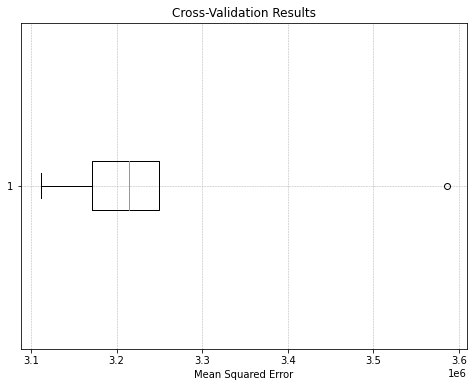

In [71]:
# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Convert negative MSE to positive
cv_results = -cv_results

print(f'Cross-Validation MSE: {cv_results}')
print(f'Mean Cross-Validation MSE: {np.mean(cv_results)}')
print(f'Standard deviation of Cross-Validation Score: {np.std(cv_results)}')

# Plot cross-validation results
plt.figure(figsize=(8, 6), facecolor='white')  # Set the figure background color to white
ax = plt.gca()
ax.set_facecolor('white')  # Set the axes background color to white

# Create the boxplot
plt.boxplot(cv_results, vert=False)
plt.xlabel('Mean Squared Error')
plt.title('Cross-Validation Results')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Optional: Add grid lines for better readability
plt.show()

**The basics:**

The boxplot helps visualize the consistency of our model's performance across different folds of the cross-validation. A tight box and short whiskers indicate consistent performance, whereas a wide box and long whiskers indicate more variability. The median and IQR provide insight into the central tendency and spread of the cross-validation results.

The presence of what appears to be a few outliers highlight potential issues or variations in performance that might need further investigation. They can be caused by particular subsets of the data that are more challenging to predict.

**Interpretation:**

Range of MSE Values: The MSE values range approximately from 3.1e6 to 3.6e6.

Median MSE: The median MSE value appears to be close to the center of the IQR box, indicating a relatively symmetrical distribution of errors within the central 50% of the data.

Outliers: The presence of outliers suggests that in some folds, the model performed significantly better or worse compared to the majority of the folds.

In [72]:
model.fit(X_train, y_train.values.ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric='rmse',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [73]:
# Predict on the validation set
y_pred = model.predict(X_test)

In [74]:
test.loc[:,'predicted_2011_cost'] = y_pred.tolist()

In [75]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428452 entries, 1914738 to 1830823
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       428452 non-null  int64  
 1   Gender                    428452 non-null  int64  
 2   Race                      428452 non-null  int64  
 3   State                     428452 non-null  int64  
 4   County                    428452 non-null  int64  
 5   SP_ALZHDMTA               428452 non-null  int64  
 6   SP_CHF                    428452 non-null  int64  
 7   SP_CHRNKIDN               428452 non-null  int64  
 8   SP_CNCR                   428452 non-null  int64  
 9   SP_COPD                   428452 non-null  int64  
 10  SP_DEPRESSN               428452 non-null  int64  
 11  SP_DIABETES               428452 non-null  int64  
 12  SP_ISCHMCHT               428452 non-null  int64  
 13  SP_OSTEOPRS               428452 non-

In [76]:
# Calculate performance metrics on the test set
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}')

MAE: 385.23385087303205, MSE: 2858379.4227136546, RMSE: 1690.6742509169692, R2: 0.99321578341852


Mean Absolute Error (MAE): Average absolute difference between predicted and actual values.

Mean Squared Error (MSE): Lower values indicate better performance.

Root Mean Squared Error (RMSE): Similar to MSE but in the same units as the target variable.

* So, the model performs pretty well since we are trying to predict total cost and the units here are dollars ($1,690.67)

R-squared (R²): Proportion of variance explained by the model (higher is better).

* That's a pretty good R-squared (0.993). Need to keep fine-tuning the hyperparamters to make sure that we are not overfitting.

C:\Users\JoeCarhart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Feature average_cost: inf
Feature Distinct_IP_CLM_ID_Count: 142.55772317771462
Feature Distinct_IP_NPI_Count: 123.99322000664445
Feature SP_ISCHMCHT: 43.84755909382783
Feature SP_DIABETES: 36.71702722242509
Feature Distinct_OP_CLM_ID_Count: 31.818914029068402
Feature Distinct_OP_NPI_Count: 29.492267905758524
Feature Avg_CLM_UTLZTN_DAY_CNT: 25.010710778851177
Feature SP_CHF: 24.37141818758471
Feature SP_CHRNKIDN: 20.925280794648064
Feature SP_COPD: 15.45053321862452
Feature SP_DEPRESSN: 14.375346668003258
Feature SP_ALZHDMTA: 14.261431742807824
Feature SP_RA_OA: 13.383653792698722
Feature SP_OSTEOPRS: 11.456295058588978
Feature BENE_ESRD_IND: 9.156298493687654
Feature SP_STRKETIA: 7.5037359415284115
Feature SP_CNCR: 6.4077540050271695
Feature Age: 1.426318517666699
Feature Gender: 1.176912553941387
Feature County: 1.1200054433305315
Feature Race: 1.0362451051822923
Feature State: 0.9354076598500667


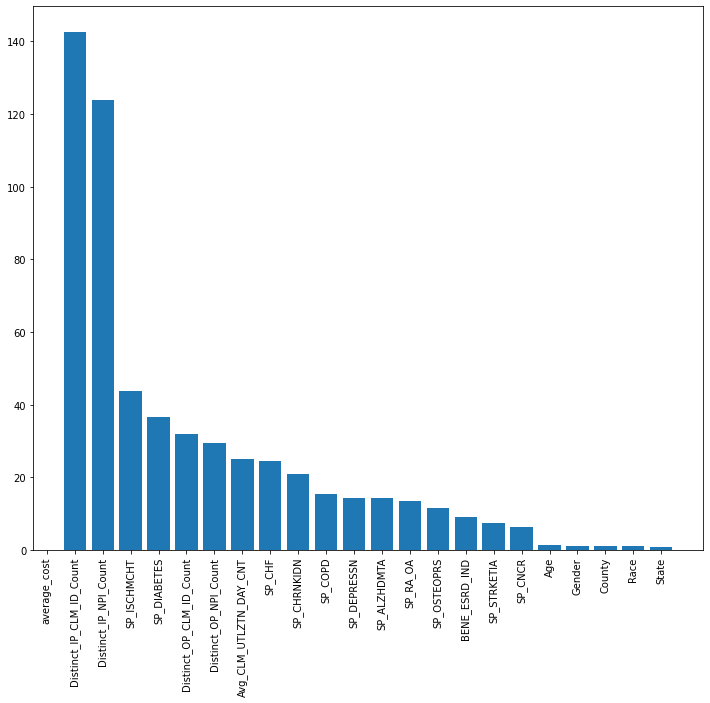

In [77]:
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train.values.ravel())
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# get feature scores and names
feature_scores = fs.scores_
feature_names = X_train.columns

# combine names and scores into a list of tuples
features_and_scores = list(zip(feature_names, feature_scores))

# sort the list of tuples in descending order of scores
features_and_scores.sort(key=lambda x: x[1], reverse=True)

# print the sorted feature scores with their names
for name, score in features_and_scores:
    print(f'Feature {name}: {score}')

# plot the sorted scores
sorted_names = [x[0] for x in features_and_scores]
sorted_scores = [x[1] for x in features_and_scores]

plt.figure(figsize=(12, 10))  # Increase the figure size
plt.bar(sorted_names, sorted_scores)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Create figure
# fig, ax = plt.subplots(figsize=(12, 10))  # Adjust the figsize as needed
# plot_importance(model, ax=ax)
# plt.show()

In [78]:
# Calculate the threshold for the top 10% of predictions
threshold = np.percentile(test['predicted_2011_cost'], 90)  # Top 10%

# Identify high-risk patients with predictions in the top 10%
high_risk_patients = test[test['predicted_2011_cost'] >= threshold]

# Extract DESYNPUF_ID and prediction for high-risk patients
high_risk_patients_list = high_risk_patients[['DESYNPUF_ID', 'predicted_2011_cost']]

# Define the file path for the output CSV file
file_path = r'C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\high_risk_patients.csv'

# Save the DataFrame to a CSV file
high_risk_patients_list.to_csv(file_path, index=False)

print(f"High-risk patients list saved to {file_path}")

High-risk patients list saved to C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\high_risk_patients.csv


In [79]:
high_risk_patients_list

,DESYNPUF_ID,predicted_2011_cost
1794817,D67A7D74FA4DEB97,"96,485.35"
853702,6609A392E2149BB8,"58,207.12"
1453459,ADAB1D43766D82EE,"71,608.48"
1861522,DE77E76E7C4110F6,"41,901.09"
159181,1306BD6CED75E1F5,"75,828.93"
...,...,...
1440052,AC1042CC29D081C7,"34,648.72"
430086,336469E21FCFCA0D,"38,641.20"
455907,3679F1432685F246,"62,343.95"
1833827,DB2672A4AE8180CA,"54,031.55"
